## ================================================================
## TIME STEP SENSITIVITY IN SINGLE-NEURON SIMULATIONS (BRIAN2)
## ================================================================
This notebook investigates the impact of numerical integration step size (**dt**) 
on the precision and stability of action potential generation in a Hodgkin–Huxley-like neuron model.  
By systematically varying **dt** (from 1 µs to 500 µs), the simulation highlights how coarse temporal discretization affects spike timing and waveform accuracy.  
The resulting traces are used to generate Supplementary Figure S1.


In [ ]:
# ------------------------------------------------
# Import required packages
# ------------------------------------------------

!pip install brian2 -q
!pip install pyparsing==3.0.9 sympy==1.12
from brian2 import *
import numpy as np
from time import time
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# ================================================================
# Parameter Setting
# ================================================================
# Define biophysical, synaptic, and network parameters.
# These include Nernst potentials, conductances, time constants,
# network geometry, and noise amplitude.

seed(1893)

Ne = 1                              # Number of excitatory neurons
El = -39.2 * mV                     # Nernst potential of leaky ions
EK = -80 * mV                       # Nernst potential of potassium
ENa = 70 * mV                       # Nernst potential of sodium
VT = -30.4*mV                       # alters firing threshold of neurons
E_ampa = 0*mV                       # reverse synaptic potential
g_ampa = 0.35*nS                    # conductance increment when spike on pre
tau_ampa = 2*ms                     # synaptic time constant AMPA
E_nmda = 0 * mV                     # Nernst potential of synaptic channels
taud_nmda = 100 * ms                # decay time constant of nmda conductance
taur_nmda = 2 * ms                  # rise time constant of nmda conductance
tau_d = 800 * ms                    # Recovery time constant of synaptic vesicles
Vmax = 25*mm/second                 # Axonal conduction velocity
grid_dist = 45 * umeter
fD = 0.075                          # Synaptic depression strength
g_nmda = 0.0275*nS                  # NMDA synaptic conductance
sigma = 5.35*mV

I_dc = 12*pA                        # DC stimulus

# ================================================================
# Definition of Cell Intrinsic and Synaptic Equations
# ================================================================
# Hodgkin–Huxley-like intrinsic dynamics with leak, Na+, and K+ currents.
# Includes AMPA and NMDA synaptic currents.

eqs = '''
dV/dt = (-gl*(V-El) - g_na*(m**3)*h*(V-ENa) - g_kd*(n**4)*(V-EK) - I_syn + I_dc)/Cm : volt
dm/dt = alpha_m*(1-m)-beta_m*m : 1
dh/dt = alpha_h*(1-h)-beta_h*h : 1
dn/dt = alpha_n*(1-n)-beta_n*n : 1
alpha_m = 0.32*(mV**-1)*4*mV/exprel((13*mV-V+VT)/(4*mV))/ms : Hz
beta_m = 0.28*(mV**-1)*5*mV/exprel((V-VT-40*mV)/(5*mV))/ms : Hz
alpha_h = 0.128*exp((17*mV-V+VT)/(18*mV))/ms : Hz
beta_h = 4./(1+exp((40*mV-V+VT)/(5*mV)))/ms : Hz
alpha_n = 0.032*(mV**-1)*5*mV/exprel((15*mV-V+VT)/(5*mV))/ms : Hz
beta_n = .5*exp((10*mV-V+VT)/(40*mV))/ms : Hz
noise = sigma*(2*gl*Cm)**.5*randn()/sqrt(dt) : amp (constant over dt)
I_syn = I_ampa+I_nmda : amp
I_ampa = g_ampa*(V-E_ampa)*s_ampa : amp
ds_ampa/dt = -s_ampa/tau_ampa : 1
I_nmda = g_nmda*(V-E_nmda)*s_nmda_tot/(1+exp(-0.062*V/mV)/3.57) : amp
s_nmda_tot : 1
x : meter
y : meter
area : meter**2
Cm = (1*uF*cm**-2) * area : farad
g_na = (50*mS*cm**-2) * area : siemens
g_kd = (5*mS*cm**-2) * area : siemens
gl = (0.3*mS*cm**-2) * area : siemens
'''

eqs_synE_model = '''
s_nmda_tot_post = s_nmda * x_d : 1 (summed)
ds_nmda/dt = -s_nmda/(taud_nmda)+x_nmda*(1-s_nmda)/taur_nmda : 1 (clock-driven)
dx_nmda/dt = -x_nmda/(taur_nmda) : 1 (clock-driven)
dx_d/dt = (1-x_d)/tau_d :1 (clock-driven)
w : 1
'''

eqs_synE_onpre = '''
s_ampa += x_d
x_nmda += 1
x_d *= (1-fD)
'''

# ================================================================
# Network Construction
# ================================================================
# Define neuron group, spatial layout, and synaptic connectivity.

cellsExc = NeuronGroup(1, model=eqs, threshold='V>0*mV', refractory=2*ms, method='exponential_euler')
cellsExc.area = 300*um**2

# Spatial distribution
cellsExc.x = 'rand() * 300 * um'
cellsExc.y = 'rand() * 300 * um'

In [ ]:
# ================================================================
# Time Step Sensitivity Analysis
# ================================================================
# Run simulations with varying integration steps (dt) to evaluate
# how the temporal resolution affects numerical stability and 
# the accuracy of the membrane potential dynamics.

traces_list = []

for dt_val in [1*us, 10*us, 100*us, 500*us]:
    defaultclock.dt = dt_val
    spikes = SpikeMonitor(cellsExc)
    traces = StateMonitor(cellsExc, 'V', record=True)
    cellsExc.V = El
    start = time()
    dur = 1*second
    run(dur, report='text')
    traces_list.append((traces.t/ms-traces.t[0]/ms, traces.V[0]/mV))

Starting simulation at t=0. s for a duration of 1. s
0.346003 s (34%) simulated in 10s, estimated 19s remaining.
0.713337 s (71%) simulated in 20s, estimated 8s remaining.
1. s (100%) simulated in 27s
Starting simulation at t=1. s for a duration of 1. s
1. s (100%) simulated in 3s
Starting simulation at t=2. s for a duration of 1. s
1. s (100%) simulated in < 1s
Starting simulation at t=3. s for a duration of 1. s
1. s (100%) simulated in < 1s


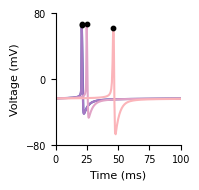

In [ ]:
# ================================================================
# Visualization and Saving
# ================================================================
# Plot membrane potential traces obtained with different integration
# time steps (dt) to visualize their impact on spike timing and shape.
# Peaks of the action potentials are identified and marked to highlight
# potential shifts introduced by varying numerical precision.

colors = ['#fbb4b9',
          '#e1a3c6',
          '#a579c4',
          '#2d4896'][::-1]

dt_list = [1*us, 10*us, 100*us, 500*us]

peak_list = []
onset_list = []

fig, ax = plt.subplots(figsize=(5.33/2.54, 5.1/2.54))

for trace, color, dt in zip(traces_list, colors, dt_list):
    time = trace[0]
    voltage = trace[1]

    ax.plot(time, voltage, color=color, label=f'{dt/us:.0f} us', zorder=0)

    peaks, _ = find_peaks(voltage)
    ax.scatter(time[peaks], voltage[peaks], s=10, color='black', label=None, zorder=1)
    peak_list.append(peaks[0]*dt/ms)

    # onset = np.where((voltage[:-1] < 0) & (voltage[1:] >= 0))[0]
    # onset_times = time[onset]
    # onset_voltages = voltage[onset]
    # ax.scatter(onset_times, onset_voltages, s=10, color='#ED2939')
    # onset_list.append(onset[0]*dt/ms)

ax.set_xlim(100, 200)
ax.set_xlabel('Time (ms)', fontsize=8)
ax.set_yticks([-80,0,80])
ax.set_xticks(ticks=[100, 125, 150, 175, 200], labels=[0, 25, 50, 75, 100])
ax.set_ylabel('Voltage (mV)', fontsize=8)
ax.set_ylim(-80, 80)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=7)

plt.tight_layout()
plt.show()
fig.savefig("AP_shift.tif", dpi=300, bbox_inches="tight")